In [2]:
from src.data.some_dataloader import RedditHyperlinkDataset, RedditPostDataset, RedditPoliticalPostDataset
from src.utils import train_utils, plot_utils, data_utils, heatmap, politics, topics_monthly, post_per_day_utils, general_utils
import importlib
import pandas as pd
importlib.reload(plot_utils)
importlib.reload(data_utils)
importlib.reload(politics)
importlib.reload(train_utils)

<module 'src.utils.train_utils' from '/home/robin/EPFL/MA1/ADA/ada-2025-project-othertagada/src/utils/train_utils.py'>

# R/GamerGate

GamerGate is the text book example of manufactured outrage.
* r/kotakuinaction (kiA)
* r/gamerghazi (giA)

## 0. Datasets used

We used the additional dataset with post content but without link to enrich the analysis.

In [ ]:
hyperlink_dataset = RedditHyperlinkDataset()
hl_data = hyperlink_dataset.data

In [ ]:
post_dataset = RedditPostDataset()
post_data = post_dataset.data

## 1. Look at the actors

### 1.1 Selection of subreddits

We restrain the dataset to relevent subreddits to this aim we select the top subreddits with the most interactions (links ingoing and outgoing) with our two principal actors to have a selection of subreddits involved in the drama. To do so we very simply calculated for each subreddit the total number of links where r/kotakuinaction and r/gamerghazi appear as source or target. This sum was done seperatedly for the two of them so our analysis was not skewed by the fact that r/kotakuinaction has more links in total. Some subredits appear in both their top ten but some are only present for one.

In [ ]:
plot_utils.plot_interactions(hl_data, 'gamerghazi', n=50)
plot_utils.plot_interactions(hl_data, 'kotakuinaction', n=50)

So only these 15 subreddits represent a good amount #insert percentage# of the links. Knowing that we have a total of #insert numbers# of subreddits in the dataset it is interesting to note that only a few restrained communities have the bulk of links to kiA and giA. These could be seen as subreddits that are part of a very specific online echo chamber. *It is to be noted that reddit is a platform inherently oriented to extremely online users and these type of drama are aimed at a very specific type of user. (to develop)*

We crop our datasets so that they only include these subreddits

In [ ]:
gamerghazi_subs = data_utils.top_connected(hl_data, 'gamerghazi', n=10)
kotakuinaction_subs = data_utils.top_connected(hl_data, 'kotakuinaction', n=10)

subs_of_interest = (set(gamerghazi_subs.index) | set(kotakuinaction_subs.index) | {'gamerghazi', 'kotakuinaction'})
hl_data_cropped = hl_data[hl_data['SOURCE_SUBREDDIT'].isin(subs_of_interest) & hl_data['TARGET_SUBREDDIT'].isin(subs_of_interest)]

print("selected population : \n", hl_data_cropped['SOURCE_SUBREDDIT'].unique())



Let's see how these subreddits interact with our main actors

In [ ]:
## BAR PLOT LINKS ##

plot_utils.plot_stacked_bar_chart(hl_data_cropped, html_output=True)

### 1.2 Population of these subreddits

1.2.1 First Let's have a look at the populations that make up reddit in general.


In [ ]:
## Histogram nb post per user ##
plot_utils.plot_histogram_nbposts_per_user(post_data, subs_of_interest)

#math description of power law# (find coef of power law if feasable)

We have a power law distribution of the number of post by users, most user are "light" user, rarely posting and some few are "power" users, users that contribute to a large amount of the content on the subreddits. "ligth" users despite their rare posting might still look at a lot of post made by others and might be actif in the act of viewing and upping a post, those could be seen as spectators. "power" users are more alike to the leaders of the subreddits.

1.2.2 Is there a difference in negativity bewtween power user and light user ? 

To this purpose we realize a t ttest with the features is_power_user = 1 if the user posted more than 50 posts in the period and in subreddits of interest and is_power_user = 0 if he posted less than or equal 50 posts. To calculate the mean sentiment we only take posts with links (i.e. main dataset) into consideration.

We use a Welch’s t-test, as we cannot assume that both groups have equal variance (Users with very few posts have a much higher variance in the estimated mean).

#describe type of t test and why#

In [ ]:
## plot average for power user against light user with variance##
## p test to see difference in link sentiment##
general_utils.t_test_negativity_users(post_data, hl_data, subs_of_interest, threshold=50)

In [ ]:
plot_utils.plot_posts_percent_positive_by_posts_per_user(post_data, hl_data, subs_of_interest)

*JE CROIS QU'IL Y A PAS* 

#p value analysis#

Oh so there is no real difference in link sentiment average for power user and light user. Great! this is useful information to get a graps on the population of reddit. Power user or light user are similarly negative.

1.2.3 Similarity between selected subreddits

To understand better how the selected subreddits interact we first need to understand how their communities of users overlap (or don't!) We compute the Jaccard Similarity between each subreddit to contruct a heatmap of user similarity between subreddits in a very intuitive way.

#description of jaccard similarity#

In [ ]:
heatmap.heatmap_user_in_commun(post_data)

A keen eye will have realised that the heatmap uses a logscale to color the values. The Jaccard similarity gives very low values that are hard to distinguish without a helpful log scaling. The low values are due to the sizes of the user set for each subreddit that are very big and with globally low overlapping. This is not suprising, as seen previoulsy, most users are light user and will not be seen on multiple subreddits.

#analysis of heatmap, most similar subreddits, least similar, anything intriguiging#

## 2. How it played out

Now that we are familiar with the actors it is time to get to work. We take advantage of the graph structure of the hypperlink dataset to plot the subreddits and display their interactions on a weekly basis for the duration of the conflict and in the aftermath. Use the slider to learn more abour the main events of Gamergate!

In [ ]:
from IPython.display import HTML

display(HTML("docs/assets/howitplayedout.html"))

ANALYSIS OF MAIN EVENTS, peaks in posts and links, define a clear date of start and end (useful for part 4)

## 3. Can negativity be predicted ?

As discussed before, this story is one of intense harassment, a huge part of managing these types of hate compaigns is content moderation. As of today content moderation relies mainly on models trained to detect hateful speach. Considering the cleaving topics discussed in gamergate, here we chose to consider a negative link from a subreddit to another as a sign of hate.

### 3.1 How negative is GamerGate ?

As a hate compaign we expect subreddits involved in the conflict to be more negative than reddit as a platform globally, but let's verify this assumption to make it a fact before going further. We compare the average negativity of the subreddits against the average of the link sentiment average per subreddit. 

In [ ]:
### À DEFINIR AU 1.1

gamergate_subs = {
    "srssucks",
    "shitghazisays",
    "kotakuinaction",
    "amrsucks",
    "drama",
    "subredditdrama",
    "againstgamergate",
    "ggfreeforall",
    "shitliberalssay",
    "kiachatroom",
    "circlebroke2",
    "gamerghazi",
    "topmindsofreddit",
    "bestofoutrageculture",
    "shitredditsays",
    "panichistory",
    }
    # 'circlebroke' and 'ggdiscussion' missing


large_gamergate_df, restricted_gamergate_df = data_utils.get_large_and_restricted_df(hl_data, gamergate_subs)

In [69]:
#BAR PLOT OF NEGATIVITY RATIO OF SUBREDDIT/GLOBAL LINK SENTIMENT AVERAGE#
plot_utils.plot_link_neg_frac(hl_data, large_gamergate_df) ## weekly as well ??
plot_utils.plot_link_neg_frac_per_subs(large_gamergate_df, gamergate_subs)


So much negativity... but yay our assumption was verfied!

PAS SURE QUE CE SPIT PERTINENT ICI, PEUT-ETRE PLUS POUR PARTIE 1

It can also be interesting to observe the negativity sent by a subreddit and compare it to the one it receives. With this analysis, we could determine in a naive way which subreddits are more aggressive in their speach and the one that are more victims of this aggressivity. Here we will simply classify the bullies and the bullied by observing which fraction is higher between the outgoing and incomig negative links for each subreddit.

In [ ]:
plot_utils.plot_in_and_out_neg_link_frac_per_subs(large_gamergate_df, gamergate_subs)

Here we can observe the following :

The more aggressive subreddits are : r/amrsucks, r/circlebroke2, r/drama, r/srssucks, r/subredditdrama.\
Two of those subreddits are clearly pro-gamergate subreddits but the others are more subreddits that debate and reacted a lot about the gamergate movement without really being on one side or another.\
The most "bullied" subreddits would be : r/panichistory, r/shitredditsays, r/bestofoutrageculture, r/againstgamergate, r/gamerghazi.\
Four of them are anti-gamergate subreddits and the other is again more of a neutral one.

Two of those subreddits are clearly pro-gamergate subreddits but the others are more subreddits that debate and reacted a lot about the gamergate movement without really being on one side or another.

The most bullied subreddits would be (top 7) : panichistory, gamerghazi, bestofoutrageculture, ggfreeforall, shitghazisays




### 3.2 Predictions of link sentiment

To detect negativity we train a model of logistic regression on the hyperlink dataset (the total dataset not the one of only the selected subreddits).

#description of logistic regression#\
For this analysis, we used the following text properties of the posts : 

"chars_no_ws", "frac_special","num_words",\
"num_long_words","avg_word_len", "frac_stopwords", "num_sentences",\
"num_long_sentences", "avg_chars_sentence","avg_words_sentence", "automated_readability",\

"vader_pos","vader_neg",\
"LIWC_Swear","LIWC_Affect","LIWC_Anger", "LIWC_Sexual"

The first 11 stylistic linguistic features would help us show how relevant the structure of a speech is in the prediction of its sentiment. We could determine if a text with an attributed sentiment tend to follow a specific structure or to have a certain complexity.

VADER values are used as well. Valence Aware Dictionary and sEntiment Reasoner is a sentiment analysis tool which is designed to analyze social media text and informal language. It is best at detecting sentiment in short pieces of text like tweets, product reviews or user comments which contain slang, emojis and abbreviations. 

Linguistic Inquiry and Word Count (LIWC) Analysis is a computational content analysis methodology that quantifies psychologically, cognitively, and socially relevant language features in free-form text. It offers 118 categories for which the statistical outputs of a text is represented as :  

$$
\text{Category Score} =
\frac{\text{Number of words in category}}
     {\text{Total number of words in text}}
\times 100\%
$$

In our dataset, only 65 categories are available and we chose to select four of them which have the most potential to be indicators of a negative sentiment in our selected communities.


Let's first naively plot a pairplot graph to see if we can identify any relationship among our chosen features or with a feature and the link sentiment we would like to predict later ... (maybe one with the whole data and another one with large gamergate)

In [ ]:
import seaborn as sns

features_to_compare_whole_df = hl_data[["LINK_SENTIMENT", "chars_no_ws", "frac_special","num_words",\
                                            "num_long_words","avg_word_len", "frac_stopwords", "num_sentences",\
                                            "num_long_sentences", "avg_chars_sentence","avg_words_sentence",\
                                            "automated_readability", "vader_pos","vader_neg",\
                                            "LIWC_Swear","LIWC_Affect","LIWC_Anger", "LIWC_Sexual"]]

sns.pairplot(features_to_compare_whole_df)


This plot is a bit hard to read but the main conclusion is here :

We find the obvious correlation between features like nb of words in a sentence with nb of characters in a sentence.

But we also have automated readability with average char sentences and avg_word sentences. --> sentences with more words tend to be more complicated to understand and needs for someone to have a better level of language to comprehend the text.

Yes it is exactly the case and looking at the ARI formula it confirms the observation.



##put formula here but nicely ARI = 4.71 avg_chars_sentence + 0.5 avg_words_sentence - 21.43##

Other than the ones we just discussed, we are not able to identify any other correlation clearly.



Let's train our regression model and see how well we can predict the link sentiment of our dataset.

#### Logistic Regression for link prediction

In [ ]:
### Logistic Regression for hl_data with feature_cols

feature_cols = ["chars_no_ws", "frac_special","num_words",\
                    "num_long_words","avg_word_len", "frac_stopwords", "num_sentences",\
                    "num_long_sentences", "avg_chars_sentence","avg_words_sentence",\
                    "automated_readability", "vader_pos","vader_neg",\
                    "LIWC_Swear","LIWC_Affect","LIWC_Anger", "LIWC_Sexual"]

tr_set, te_set = train_utils.train_test_set(hl_data)
X_tr, y_tr, X_te, y_te = train_utils.data_scaling_for_training(tr_set, te_set, feature_cols, None)

In [ ]:
# simple Logistic Regression with statsmodels
logistic_reg, pred = train_utils.sm_log_reg(X_tr, y_tr, X_te, y_te)

Training on the whole dataset, we get an prediction accuracy of 0.807 which is pretty satisfying. Now let's see how well the model predict the outgoing link sentiment of each of our selected subreddits.

In [ ]:
plot_utils.inter_plot_pred_accuracy_per_subs(te_set, pred, gamergate_subs, "Prediction accuracy per subreddits (hl_data)", "docs/assets/pred_accuracy_per_subs_hl_data.html")

It is clearly less satisfying... 
The accuracy is less than 0.8 for all subreddits and even less than 0.5 for three of them. 
Since we trained on the whole dataset, our model is not fitting all the data from the selected subreddits very well. It represents only a small fraction of the whole dataset.
However, among the subreddits with the most accurate predictions, we can find r/drama, r/circlebroke2 and r/subredditdrama, the same that were classified as "bullies" in our previous analysis but were actually not in a particular side. Why is that ?

Let's look at this next plot to get a better understanding.

In [ ]:
plot_utils.plot_out_pos_neg_link_per_subs(large_gamergate_df, gamergate_subs)

The answer is acutually very simple. They are among the most active subreddits of our selection, which means that they will have more impact on the model that we trained than the other smaller subreddits with only a few posts on their account.

To go futher with this analysis we want to figure out which feature had the most weight in the decision making of our model. This is where we introduce the feature coefficient of the model that will help us determine the importance of each feature and in which direction they lead us (positive or negative). 
\
\
But, to keep things a little bit more interesting, let's train an other model but with only the large_gamergate_df. That way we can compare the importance of the features in the link sentiment prediction in our chosen gamergate-related subreddits and in Reddit as a whole.

In [ ]:

train_set, test_set = train_utils.train_test_set(large_gamergate_df)
X_train, y_train, X_test, y_test = train_utils.data_scaling_for_training(train_set, test_set, feature_cols, None)


In [ ]:
log_reg, prediction = train_utils.sm_log_reg(X_train, y_train, X_test, y_test)


In [ ]:
#plot of accuracy#
plot_utils.inter_plot_pred_accuracy_per_subs(test_set, prediction, gamergate_subs, "Prediction Accuracy per gamergate subreddits (gamergate_subs)", "docs/assets/pred_accuracy_gamergate_subs.html")

Overall accuracy lower than the other one but accuracy per subs a bit better : only 4 under 0.7 against 10 in the previous model

#discussion of accuracy, overfitting ?#

### 3.3 What are signs of negativity on reddit?

3.2.1 Feature importance

The logistic regression model is useful not only to classify a link as negative or positive but it also gives us a glimpse into which features are the most useful in the classification and if their presence has a positive or negative impact on the link sentiment.

In [ ]:
## Whole dataset

coef_dataf = plot_utils.plot_feature_coef_and_significance(logistic_reg, feature_cols, "Logistic Regression Feature coefficients (hl_data)", "docs/assets/feature_coef_hl_data.html")

plot_utils.feature_coef_significance_grid(coef_dataf, "Logistic Regression Feature significance (hl_data)", "docs/assets/feature_significance_hl_data.html")

most important in positive prediction = automated readability, num_words, vader_pos
most important in negative prediction = ...


In [ ]:

## gamergate subs
coef_df = plot_utils.plot_feature_coef_and_significance(log_reg, feature_cols, "Logistic Regression Feature coefficients (gamergate_subs)", "docs/assets/feature_coef_gamergate_subs.html")

plot_utils.feature_coef_significance_grid(coef_df, "Logistic Regression Feature significance (gamergate_subs)", "docs/assets/feature_significance_gamergate_subs.html")



#Discussion of the results, what can be said about the most important features#
The semantic and linguistic features seem to have a bigger role at play than sentiment and topic based features. So the way a post is written is more telling than the topics detected to predict a negative link. (to develop with results)

## 4. Impact of manufactured outrage on politics (rough first draft)

GamerGate has been widely analysed post mortem and is now considered a text book exmaple of manifactured online outrage. Pushing communinities to more extrem views and all of these discutions are inherently political. (to develop)
We are not saying that GamerGate had any influence on the 2017 election, we are looking at the rise in online right wing extremism at the time and how online spaces were used to influence the election. (to reformulate I'm aware this is bad :)
* 4.1 word topic cluster (bubbles) with political topics to show political importance (The_donald political sub)
* 4.2 analysis of post gamergate plolitical leanings in Gamer subreddit or selected subreddit vs pre Gamergate (a voir si vrai ou pas)


In [ ]:
politics_dataset = RedditPoliticalPostDataset('data/politics_post_data.csv')
politics_data = politics_dataset.data

In [ ]:
gaming_dataset = RedditPostDataset('data/gamergate_post_data_old.csv')
gaming_data = gaming_dataset.data
gaming_data = gaming_data[gaming_data['SUBREDDIT'] == 'gaming']

In [ ]:
importlib.reload(politics)
politics.proportion_of_gg_in_politics_multiple_lines(post_data, politics_data)

In [ ]:
importlib.reload(politics)
politics.proportion_of_gg_in_politics(post_data, politics_data)

In [ ]:
importlib.reload(politics)
politics.proportion_of_gg_in_politics(gaming_data, politics_data)

## 5. What becomes of these communites after the facts ?

While r/kotakuinaction and r/gamerghazi where created expressively with the goal of discussing the subject of GamerGate, these subreddits (like many others) do not die down suddenly after the events. These subreddits continue posting years after the peak of the conflict, identified earlier as starting from #insert start date# and lasting approximatively until #insert end date#.

### 5.1 Decline in activity...

It is not surprising that the activity slows down significantly

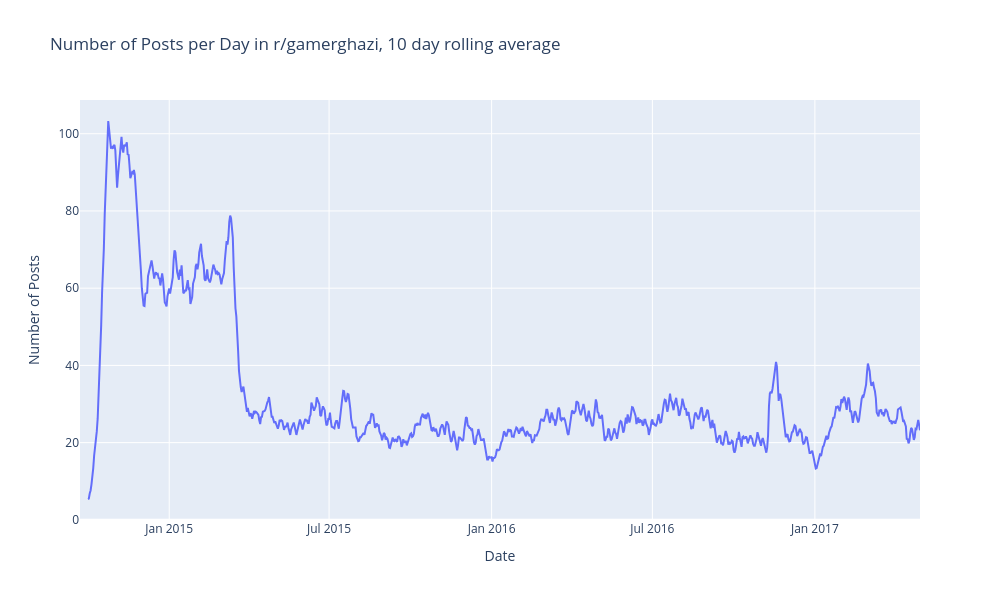

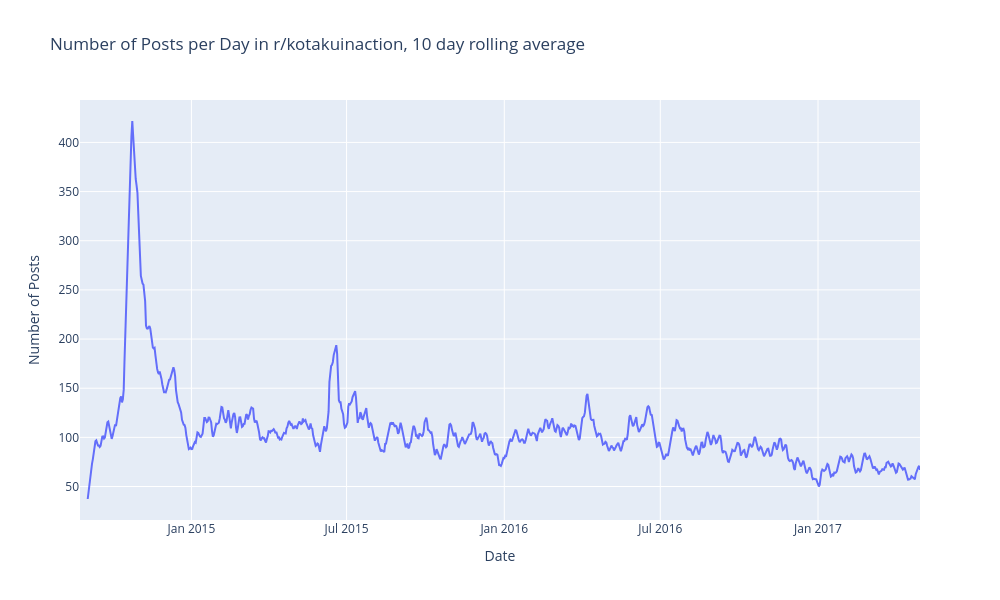

In [3]:
#plot nb of post per week both#
posts_per_day = pd.read_csv("data/zst_posts_per_day_per_sub.csv")
post_per_day_utils.plot_posts_per_day(["gamerghazi", "kotakuinaction"], posts_per_day)

We can see a clear peak when "Gamer gate" happened and a rapid decline with subsequent stabilization.

### 5.2 ...But the activity is not null

So what are the discussion made of if echanges are still being made on those subreddits ? To analyze the changing trends in the topics discussed on each subreddit we have turn NLP technics (Natural Language Processing).\

5.2.1 Creation of topic categories

We use the tool Empath #link to description of empath# to create categories of topics related to our analysis.\
#description of Empath#\

In [ ]:
from empath import Empath
lexicon = Empath()

Empath even offers a model trained on data from reddit that is perfect for our analysis, sweet!

Our custom topics :
* Gamergate : Everything related to the actual events that sparked gamergate
* Mysogyny : Signs of mysogyny, sexims and violence against women.
* Legal : Legal speech, trial 
* Incel : Incel retoric

In [ ]:
lexicon.create_category("misogyny", ['sexism', 'insults', 'harassment', 'body', 'sexual'], model="reddit")
lexicon.create_category('gamergate', ['gaming', 'review', 'cheating'],model='reddit')
lexicon.create_category('legal', ['legal', 'trial', 'FBI', 'threat'], model='reddit')
lexicon.create_category('incel', ['men', 'incel', 'society'], model='reddit')

The output given by empath seems relevant term such as #insert terms# and #other terms# were correctly infered from the given seed words. 

5.2.2 Monthly analysis

We compute the normalize values of relevance for each topic monthly. 

In [ ]:
importlib.reload(topics_monthly)
collection_kia = topics_monthly.create_collection('outputs/subreddit_text_documents_monthly/kotakuinaction')
topics_monthly.plot_monthly_topic(collection_kia, lexicon)

In [ ]:
importlib.reload(topics_monthly)
collection_gia = topics_monthly.create_collection('outputs/subreddit_text_documents_monthly/gamerghazi')
topics_monthly.plot_monthly_topic(collection_gia, lexicon)

We can see a clear peak in the gamergate topics coienciding with the peak in post on the subreddit at #insert date#.\
Decline in interest in main topic.\
In r/gamerghazi, in the aftermath, the subreddit is mostly used to discuss the incel movement.(to develop)\
Legal picks up in importance as the legal ramifications of GamerGate slowly surface. Did you know that the FBI was implicated multiple times in this story ?!


5.2.3 Comparaison with baseline

Just to be sure of our technic let's see what happens when we compute the same values for a subreddit that is not part of the gamerghazi drama. We chose the very active r/gaming subreddit.

In [ ]:
importlib.reload(topics_monthly)
collection_gaming = topics_monthly.create_collection('outputs/subreddit_text_documents_monthly_gaming/gaming')
topics_monthly.plot_monthly_topic(collection_gaming, lexicon)

The topics look almost irrelevant for this subreddit, this confirm that our analysis had grounds. 

## 6. Conclusion